# Classification
## MI201

##**Group 4** :
- Diego FLEURY CORRÊA DE MORAES
- Hazael SOLEDADE DE ARAUJO JUMONJI
- Lucas DE OLIVEIRA MARTIM

### Project 3 : **Sentiment Analysis Using LLMs**

In [1]:
! git clone https://github.com/DiegoFleury/MI201-groupe-4.git

Cloning into 'MI201-groupe-4'...
remote: Enumerating objects: 254, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 254 (delta 29), reused 10 (delta 3), pack-reused 198 (from 2)
Receiving objects: 100% (254/254), 242.32 MiB | 18.84 MiB/s, done.
Resolving deltas: 100% (116/116), done.
Updating files: 100% (25/25), done.


# Introduction

We've decided to separate this notebook on a per-model basis. The data structures and approaches to each of the segments is way too heterogenous to attempt to unify them all under a single procedure, in a manner that's neither unrepresentative nor forced.

The notebook is divided in 3 main parts. The first 2 represent each
one form of LLM usage (**Feature-based** or **Finetuned**) based upon the ideas
discussed in the paper :

- **Feature-based**
  - Classical Machine Learning
  - Neural Networks
- **Finetuning-based**
  - BERT and roBERTa (*Classical Finetuning*)
  - BERT and roBERTa (*LoRA Finetuning*)

In order to provide a richer discussion, we've also added a third section, in which we used an API to get predictions from bigger LLM models. This has the goal of not only serving as a base for comparison, but also getting an idea on how good really can a model actually perform on the dataset.

- **Deepseek v3**

With this, we hope to have been able to show the differences between each approach.

# Importing and Installing libraries

In [2]:
! pip install umap-learn numba llamaapi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.0 MB/s eta 0:00:00


In [23]:
# Data handling
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Ploting
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Text preprocessing
import re
import unicodedata

# BERT
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, TrainingArguments, Trainer

# Deep learning
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim

# Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Dimensionality reduction
import umap
import numba
from sklearn.manifold import TSNE

# Classic ML models
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost

# Model selection
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score

# LLM API
import json
from llamaapi import LlamaAPI
import time

# LoRA
from peft import LoraConfig, get_peft_model, TaskType
from transformers import TrainingArguments
import os

# Data Handling

Let's take the already processed datasets, a result of the preProcessingAndEDA notebook.

## Initializing the DataFrames

In [4]:
data_path = "MI201-groupe-4/Data/"

In [5]:
# Load the data
train_full = pd.read_csv(data_path + 'processed_train.csv')
test_full =  pd.read_csv(data_path + 'processed_test.csv')

# Drop any null values
train_full.dropna(inplace=True)
test_full.dropna(inplace=True)

# Perform the proper separation of functions of each dataset
X_train, X_val, y_train, y_val = train_test_split(train_full['Text'], train_full['Sentiment'], test_size=0.2, random_state=42)
X_test, y_test = test_full['Text'], test_full['Sentiment']

# Correct the indexes of all tables
X_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

y_train.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

## Preprocessing the DataFrames

In [6]:
# Preprocessing the text, just enough to not lose any important features

def preprocess_text(text):
    """
    Text preprocessing, removing accents, links, HTML, extra spaces and user names.

    - Converts to lowercase.
    - Removes accents.
    - Removes HTML tags.
    - Remove links (http, https, www).
    - Removes extra spaces.
    - Removes user names.
    """

    if not isinstance(text, str):
        return ""

    # Lowercase
    text = text.lower()

    # Strip all accents
    text = ''.join(c for c in unicodedata.normalize('NFKD', text) if unicodedata.category(c) != 'Mn')

    # Removes links (http, https, www)
    text = re.sub(r"http\S+|www\S+", "", text)

    # Removes HTML tags
    text = re.sub(r"<.*?>", "", text)

    # Removes usernames
    text = re.sub(r"@\w+", "", text)

    # Removes line breaks and excessive whitespaces
    text = re.sub(r"\s+", " ", text).strip()

    return text

# Also need to preprocess the labels. Mapping made like this to preserve
# the ordinal character of the feature. Also, isn't zero-centered
# due to the input requirements of XGBoost
sentiment_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}

In [7]:
# Apply the preprocessing to the features
X_train = X_train.apply(preprocess_text)
X_val = X_val.apply(preprocess_text)
X_test = X_test.apply(preprocess_text)

In [8]:
X_train

,Text
0,"oh, he`s hilarious. i`m just commenting on the..."
1,"thanks for trying i was hoping bud trillin, bu..."
2,after show at our house rocked! saying goodbye...
3,up at 4:30am west coast time..gettin ready to ...
4,my computer is so slooowww this morning. i thi...
...,...
21979,feels like warm things
21980,my best friend is in vegas without me
21981,- fire and urban at rock challenge
21982,a+ for effort though


In [9]:
# Apply the preprocessing to the labels
y_train = y_train.map(sentiment_mapping)
y_val = y_val.map(sentiment_mapping)
y_test = y_test.map(sentiment_mapping)

In [10]:
y_train

,Sentiment
0,2
1,2
2,1
3,2
4,1
...,...
21979,1
21980,1
21981,1
21982,2


## Creating Pytorch Data Objects

In [11]:
# Custom Dataset object created to store the original texts
# and return them in the form of it's tokenizer's parameters (ids, attention mask) and label
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        """
        Args:
            texts (DataFrame): DataFrame with the text samples.
            labels (DataFrame): DataFrame of sentiment labels (e.g., 0, 1).
            tokenizer (transformers.BertTokenizer): Tokenizer for BERT.
            max_length (int): Maximum length for tokenized sequences.
        """
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # Tokenize and encode the text
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }

In [12]:
# Custom Dataset object created to store the embedded version of each text ()
class EmbeddingDataset(Dataset):
    def __init__(self, embeddings, labels):
        """
        Args:
            embeddings (numpy array): Representation of embedding of the hole text ([CLS] token with context).
            labels (DataFrame): DataFrame of sentiment labels (e.g., 0, 1).
        """
        self.embeddings = embeddings
        self.labels = labels

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        # Tokenize and encode the text
        embeddings = self.embeddings[idx]
        label = self.labels[idx]

        return {
            "input_ids": embeddings,
            "label": torch.tensor(label, dtype=torch.long)
        }

In [13]:
# Extract embeddings for all data
# effectively converting from one representation (Text) to the other (Embedding)
def extract_embeddings(model, dataloader, device):
    """
    Extracts embeddings for all data using a pre-trained BERT model.

    Args:
        model (transformers.BertModel): Pre-trained BERT model.
        dataloader (DataLoader): DataLoader for the dataset.
        device (torch.device): Device to run the model on (CPU or GPU).

    Returns:
        torch.Tensor: A matrix of size (number_of_samples, embedding_size).
    """
    model.eval()  # Set the model to evaluation mode
    embeddings = []

    with torch.no_grad():  # Disable gradient computation
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            # Forward pass through BERT
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            pooled_output = outputs.pooler_output  # CLS token representation

            # Append embeddings to the list
            embeddings.append(pooled_output.cpu())

    # Combine all embeddings into a single matrix
    return torch.cat(embeddings, dim=0)

In [14]:
# Hyperparameters
PRETRAINED_MODEL = "cardiffnlp/twitter-roberta-base-sentiment" # "bert-base-uncased"
MAX_LENGTH = 256 # Tweets can have at most 280 characters, but let's keep it a power of 2
BATCH_SIZE = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL)

# Initialize the datasets
train_dataset = TextDataset(X_train, y_train, tokenizer, MAX_LENGTH)
val_dataset = TextDataset(X_val, y_val, tokenizer, MAX_LENGTH)
test_dataset = TextDataset(X_test, y_test, tokenizer, MAX_LENGTH)

# Initialize the dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [15]:
def process_embeddings(extract_embeddings, data_loader, model_name, device, file_path):
    """
    Processes embeddings for a given dataset.

    If file_path exists, loads embeddings from the file.
    Otherwise, extracts embeddings using the model and saves them.

    Args:
        extract_embeddings: Function to extract embeddings.
        data_loader: DataLoader for the dataset.
        model_name: Name of the pre-trained model.
        device: Execution device (cuda or cpu).
        file_path: Path to save or load embeddings.

    Returns:
        embeddings : Matrix of size (number_of_samples, embedding_size).
    """
    if file_path:
        try:
            embeddings = np.load(file_path)
            return embeddings
        except FileNotFoundError:
            pass

    # Load model
    bert = AutoModel.from_pretrained(model_name).to(device)

    # Extract embeddings
    embeddings = extract_embeddings(bert, data_loader, device).cpu().numpy()

    # Save embeddings
    np.save(file_path, embeddings)

    return embeddings

In [16]:
train_embeddings = process_embeddings(extract_embeddings, train_loader, PRETRAINED_MODEL, device, data_path + "roberta_train_embeddings.npy")
val_embeddings = process_embeddings(extract_embeddings, val_loader, PRETRAINED_MODEL, device,     data_path + "roberta_val_embeddings.npy")
test_embeddings = process_embeddings(extract_embeddings, test_loader, PRETRAINED_MODEL, device,   data_path + "roberta_test_embeddings.npy")

In [17]:
train_embeddings.shape, val_embeddings.shape, test_embeddings.shape

((21984, 768), (5496, 768), (3534, 768))

In [18]:
# Initialize the embedding datasets
embedding_train_dataset = EmbeddingDataset(train_embeddings, y_train)
embedding_val_dataset = EmbeddingDataset(val_embeddings, y_val)
embedding_test_dataset = EmbeddingDataset(test_embeddings, y_test)

# Initialize the embedding dataloaders
embedding_train_loader = DataLoader(embedding_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
embedding_val_loader = DataLoader(embedding_val_dataset, batch_size=BATCH_SIZE, shuffle=True)
embedding_test_loader = DataLoader(embedding_test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Feature-Based

## Classical ML (Logistic Regression, SVM, Random Forest, XGBoost)

**Q1** - please perform a classification with differents classical machine learning model and analyse the performences

### UMAP

Upon noticing that the classical machine learning models struggled to generate their results within practical time limits, we've opted to reduce their dimensionality first.

For this task, using UMAP makes semantic sense due to the way it operates. UMAP preserves the topological connectivity of the data by maintaining nearest neighbors in the lower-dimensional projection. This characteristic aligns well with our goal since, as discussed in another notebook, preserving proximity in the embedding space corresponds to maintaining semantic similarity. In other words, if objects are close in the high-dimensional space, they remain close in the projected space, ensuring that meaningful relationships in the data are retained.

Moreover, it is common practice to apply UMAP for dimensionality reduction on embeddings obtained from BERT. Given that BERT embeddings capture contextual semantics, UMAP has been shown to perform well in maintaining these relationships while significantly reducing computational overhead. This makes it a suitable choice for our scenario, where we aim to balance efficiency with the preservation of meaningful structure in the data.

In [19]:
umap_model = umap.UMAP(n_components=50, n_neighbors=30, min_dist=0.1, metric = "cosine")

In [20]:
def process_umap_transform(umap_model, embeddings, file_path):
    """
    Applies UMAP transformation to embeddings.

    If file_path exists, loads transformed embeddings from the file.
    Otherwise, applies UMAP and saves the transformed embeddings.

    Args:
        umap_model: Pre-trained UMAP model.
        embeddings: Original embeddings to be transformed.
        file_path: Path to save or load transformed embeddings.

    Returns:
        Transformed embeddings.
    """
    if file_path:
        try:
            transformed_embeddings = np.load(file_path)
            return transformed_embeddings
        except FileNotFoundError:
            pass

    transformed_embeddings = umap_model.fit_transform(embeddings) if 'train' in file_path else umap_model.transform(embeddings)
    np.save(file_path, transformed_embeddings)
    return transformed_embeddings

In [21]:
train_embeddings_umap = process_umap_transform(umap_model, train_embeddings, data_path + "roberta_train_embeddings_umap.npy")
val_embeddings_umap = process_umap_transform(umap_model, val_embeddings, data_path + "roberta_val_embeddings_umap.npy")
test_embeddings_umap = process_umap_transform(umap_model, test_embeddings, data_path + "roberta_test_embeddings_umap.npy")

In [22]:
train_embeddings.shape, train_embeddings_umap.shape

((21984, 768), (21984, 50))

**Q0** - please analyse the datasets with classical ML algorithms

Let's analyse the quality of the UMAP embeddings. T-SNE is likely the best option to perform this.

In [24]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)

train_embeddings_umap_tsne = tsne.fit_transform(train_embeddings_umap)
val_embeddings_umap_tsne = tsne.fit_transform(val_embeddings_umap)
test_embeddings_umap_tsne = tsne.fit_transform(test_embeddings_umap)

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


As we can see, there's plenty of overlap in the training set with respect to the neutral label, as it makes sense, not only due to the semantic nature, but also due to the fact that it's the hardest, as simply saying one positive and one negative thing in a sentence (e.g. "Great news, I've been promoted ... to costumer") can result still in overall negativeness or positiveness, not necessarily in a neutral label (it's not as simple as interpolation of how much the sentence is negative vs positive).

It's interesting to see that negative and positive phrases actually "turn around" and meet eachother, however, this may be a result of artifacts of the t-sne procedure. Nevertheless, it seems to hold some truth, as it is somewhat maintained in the validation and test sets.

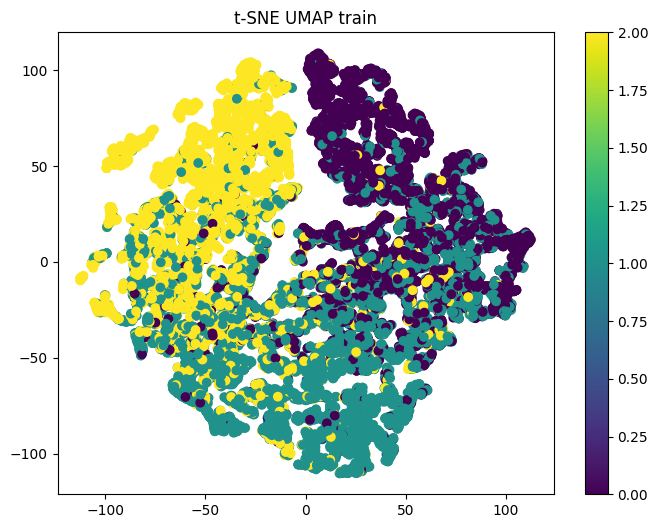

In [25]:
plt.figure(figsize=(8, 6))
plt.scatter(train_embeddings_umap_tsne[:, 0], train_embeddings_umap_tsne[:, 1], c=y_train, cmap='viridis')
plt.colorbar()
plt.title('t-SNE UMAP train')
plt.show()

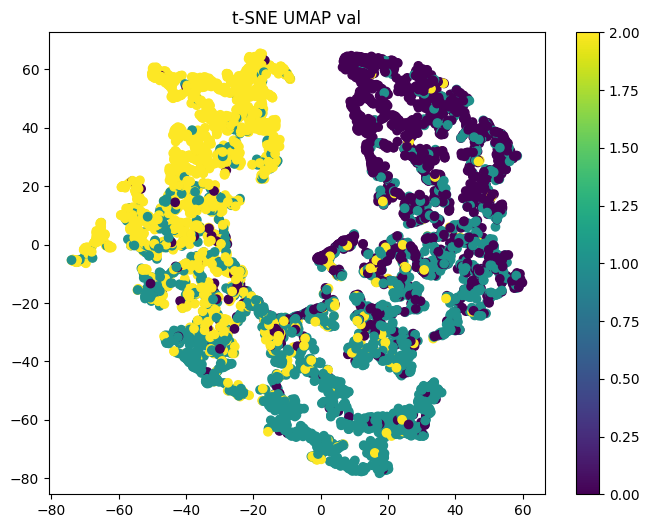

In [27]:
plt.figure(figsize=(8, 6))
plt.scatter(val_embeddings_umap_tsne[:, 0], val_embeddings_umap_tsne[:, 1], c=y_val, cmap='viridis')
plt.colorbar()
plt.title('t-SNE UMAP val')
plt.show()

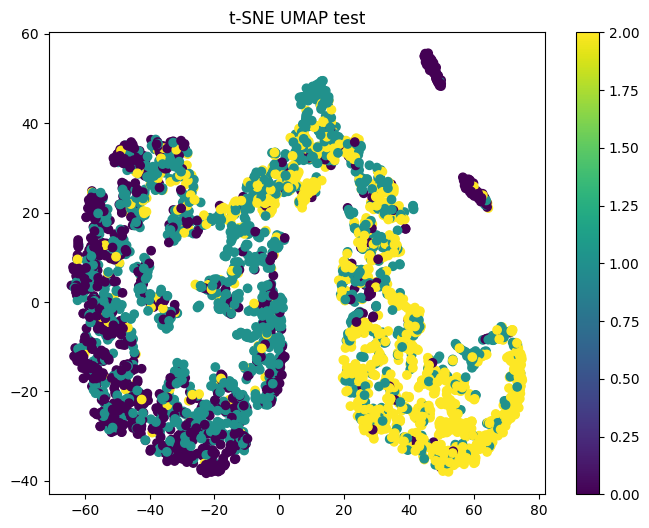

In [29]:
plt.figure(figsize=(8, 6))
plt.scatter(test_embeddings_umap_tsne[:, 0], test_embeddings_umap_tsne[:, 1], c=y_test, cmap='viridis')
plt.colorbar()
plt.title('t-SNE UMAP test')
plt.show()

### Logistic Regression

In [ ]:
# Criar e treinar o modelo de Regressão Logística
logreg = LogisticRegression(
    max_iter=500,       # Número máximo de iterações para convergência
    C=1.0,              # Regularização (1.0 = padrão, pode ajustar)
    solver="lbfgs",     # Otimizador (funciona bem para embeddings grandes)
    multi_class="multinomial",  # Para classificação multiclasse
    n_jobs=-1           # Usa múltiplos núcleos da CPU
)

logreg.fit(train_embeddings_umap, y_train)

# Avaliação
accuracy = logreg.score(val_embeddings_umap, y_val)
print(f"Validation Accuracy: {accuracy:.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Validation Accuracy: 0.7536


### SVM

Instead of using a standard SVM, which scales poorly with large datasets due to its high computational cost, we opted for two more efficient variants: **SGDClassifier** and **LinearSVC**. **SGDClassifier** leverages stochastic gradient descent, making it suitable for large-scale problems by updating the model incrementally, which significantly improves training speed. **LinearSVC**, on the other hand, solves the optimization problem more efficiently than traditional SVMs by using a linear kernel and an optimized implementation that avoids storing the full kernel matrix. Both approaches allow us to retain the advantages of SVMs while ensuring practical runtime performance for high-dimensional data.

In [ ]:
svm_sgd = SGDClassifier(loss='hinge', alpha=0.01, max_iter=2000, tol=1e-3)
svm_sgd.fit(train_embeddings_umap, y_train)

print(f"Accuracy: {svm_sgd.score(val_embeddings_umap, y_val):.4f}")

Accuracy: 0.7485


In [ ]:
svm = LinearSVC(C=1.0, max_iter=5000)
svm.fit(train_embeddings_umap, y_train)

print(f"Validation Accuracy: {svm.score(val_embeddings_umap, y_val):.4f}")

Validation Accuracy: 0.7533


### Random Forest

In [ ]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    n_jobs=-1,
    random_state=42
)

rf.fit(train_embeddings_umap, y_train)

accuracy = rf.score(val_embeddings_umap, y_val)
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.7586


### XGBoost

In [ ]:
xgb = XGBClassifier(
    n_estimators=100,  # Number of trees
    max_depth=5,       # Maximum depth of each tree
    learning_rate=0.01, # Learning rate of the ensemble
    use_label_encoder=False,  # To avoid unnecessary warnings
    eval_metric="mlogloss"  # Multiclass classification metric
)

xgb.fit(train_embeddings_umap, y_train)

accuracy = xgb.score(val_embeddings_umap, y_val)
print(f"Validation Accuracy: {accuracy:.4f}")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:49:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Validation Accuracy: 0.7604


Lets take only the random forest classifier as a model to be tested further (not suprisingly, an ensemble methods!). It's the second best performing and we've had some issues with the library version for xgboost.

In [ ]:
def perform_grid_search(model, param_grid, X, y, cv=2, scoring='accuracy', verbose=10):
    """
    Performs GridSearchCV for a given model and parameter grid.

    Args:
        model: The machine learning model.
        param_grid: Dictionary of hyperparameters to search.
        X: Feature matrix.
        y: Target labels.
        cv: Number of cross-validation folds (default: 2).
        scoring: Scoring metric (default: 'accuracy').
        verbose: Verbosity level (default: 10).

    Returns:
        Best parameters and best score from the grid search.
    """
    grid = GridSearchCV(model, param_grid, cv=cv, scoring=scoring, verbose=verbose)
    grid.fit(X, y)
    print("Best parameters:", grid.best_params_)
    print("Best accuracy:", grid.best_score_)
    return grid.best_params_, grid.best_score_

In [ ]:
# Random Forest
rf = RandomForestClassifier()

rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10]
}

rf_best_params, _ = perform_grid_search(rf, rf_param_grid, train_embeddings_umap, y_train)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV 1/2; 1/4] START max_depth=5, n_estimators=100...............................
[CV 1/2; 1/4] END max_depth=5, n_estimators=100;, score=0.755 total time=   6.8s
[CV 2/2; 1/4] START max_depth=5, n_estimators=100...............................
[CV 2/2; 1/4] END max_depth=5, n_estimators=100;, score=0.753 total time=   9.8s
[CV 1/2; 2/4] START max_depth=5, n_estimators=200...............................
[CV 1/2; 2/4] END max_depth=5, n_estimators=200;, score=0.756 total time=  16.3s
[CV 2/2; 2/4] START max_depth=5, n_estimators=200...............................
[CV 2/2; 2/4] END max_depth=5, n_estimators=200;, score=0.751 total time=  13.4s
[CV 1/2; 3/4] START max_depth=10, n_estimators=100..............................
[CV 1/2; 3/4] END max_depth=10, n_estimators=100;, score=0.758 total time=   9.0s
[CV 2/2; 3/4] START max_depth=10, n_estimators=100..............................
[CV 2/2; 3/4] END max_depth=10, n_estimators=100;

In a real life situation we'd test far more models under far more combinations of values and models, but this is just a illustration of the level that classical ML models can achieve in this dataset.

## Neural Network

**Q2** - please perform a classification with a MLP

### Deep Neural Network Classifier

In [ ]:
class SentimentClassifier(nn.Module):
    def __init__(self, input_dim=768, hidden1=1024, hidden2=2048, output_dim=3, dropout=0.1):
        super(SentimentClassifier, self).__init__()

        # Activation function
        self.activation = nn.GELU()

        # Main layers (notice the middle increase in size, followed by a decrease)
        self.fc1 = nn.Linear(input_dim, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, hidden1)
        self.fc4 = nn.Linear(hidden1, input_dim)

        # Output layer (3 classes)
        # Softmax is not here due to the fact that it's implemented
        # fused with the loss for efficiency
        self.fc_out = nn.Linear(input_dim, output_dim)

        # Dropout layer (regularization)
        self.dropout = nn.Dropout(dropout)

        # Batch norm layers (regularization)
        self.bn1 = nn.BatchNorm1d(hidden1)
        self.bn2 = nn.BatchNorm1d(hidden2)
        self.bn3 = nn.BatchNorm1d(hidden1)

    def forward(self, x):

        # Stores the input to implement skip connections
        skip = x

        x = self.fc1(x)
        x = self.bn1(x)
        x = self.activation(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.activation(x)
        x = self.dropout(x)

        x = self.fc3(x)
        x = self.bn3(x)
        x = self.activation(x)
        x = self.dropout(x)

        x = self.fc4(x)
        x = self.activation(x)

        x = x + skip  # Skip connection

        x = self.fc_out(x)
        return x


### Epoch Loops

In [ ]:
# Training script (assumes it uses the Embedded Dataset)
def train( model, train_loader, optimizer, criterion, epoch,log_interval=50):
    model.train()

    loss_cpu=0
    correct = 0
    total = 0

    for batch_idx, data in enumerate(train_loader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, target = data['input_ids'],data['label']
        inputs, target = inputs.cuda(), target.cuda()

        # inputs =inputs.detach()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, target)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient Clipping

        optimizer.step()

        # Softmax here
        _, predicted = torch.max(outputs.data, 1)
        loss_cpu+= loss.item()
        total += target.size(0)
        correct += predicted.eq(target.data).cpu().sum()

        if batch_idx % log_interval == 0:
            print('| Epoch [%3d/%3d] Iter[%3d/%3d]\t\tLoss: %.4f Acc@1: %.3f%%'
                %(epoch, EPOCHS, batch_idx+1,
                    (len(train_loader)//BATCH_SIZE)+1, loss.item(), 100.*correct/total))
            #n_iter=epoch * len(train_loader) + batch_idx

    return loss_cpu/len(train_loader)

In [ ]:
# Testing script (assumes it uses the Embedded Dataset)
def test( model, test_loader, criterion ,epoch):
    model.eval()

    correct = 0
    total = 0
    test_loss = 0

    with torch.no_grad():
        for batch_idx, data in enumerate(test_loader, 0):
            inputs, target = data['input_ids'],data['label']
            inputs, target = inputs.cuda(), target.cuda()

            outputs  = model(inputs)
            loss = criterion(outputs,target)

            # Softmax here
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += predicted.eq(target.data).cpu().sum()
            test_loss += loss.item()

    test_loss = test_loss/ len(test_loader)
    print("\n| Validation Epoch #%d\t\t\tLoss: %.4f Acc@1: %.2f%%" %(epoch, loss.item(), 100.*correct/total))
    return test_loss, 100.*correct/total

### Training

In [ ]:
LEARNING_RATES = [5e-6, 2e-6, 1e-6]
EPOCHS = 60
PATIENCE = 7

# To compare all the losses
all_train_losses = {}
all_val_losses = {}

for lr in LEARNING_RATES:

    print(f"\nTraining with lr = {lr}")

    model = SentimentClassifier().to(device)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)  # Slight L2 Regularization
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)  # Gradual LR reduction

    train_losses = []
    val_losses = []

    best_val_loss = float("inf")
    patience_counter = 0

    # Go through all epochs
    for epoch in range(EPOCHS):
        train_loss = train(model, embedding_train_loader, optimizer, criterion, epoch)
        val_loss, val_acc = test(model, embedding_val_loader, criterion, epoch)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Update the learning rate with the scheduler
        scheduler.step()

        # Early Stopping: stop if the validation loss hasn't got any better for "PATIENCE" epochs
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print(f"⏹️ Early Stopping activated in epoch {epoch+1} for LR {lr}.")

                # Padding the remaining epochs
                train_losses.extend([train_losses[-1]] * (EPOCHS - len(train_losses)))
                val_losses.extend([val_losses[-1]] * (EPOCHS - len(val_losses)))
                break

    all_train_losses[f"LR {lr}"] = train_losses
    all_val_losses[f"LR {lr}"] = val_losses


Training with lr = 5e-06
| Epoch [  0/ 60] Iter[  1/  6]		Loss: 1.1359 Acc@1: 28.125%
| Epoch [  0/ 60] Iter[ 51/  6]		Loss: 0.7200 Acc@1: 65.870%
| Epoch [  0/ 60] Iter[101/  6]		Loss: 0.6024 Acc@1: 69.477%
| Epoch [  0/ 60] Iter[151/  6]		Loss: 0.6511 Acc@1: 71.151%
| Epoch [  0/ 60] Iter[201/  6]		Loss: 0.5885 Acc@1: 71.914%
| Epoch [  0/ 60] Iter[251/  6]		Loss: 0.5529 Acc@1: 72.603%
| Epoch [  0/ 60] Iter[301/  6]		Loss: 0.5325 Acc@1: 72.991%

| Validation Epoch #0			Loss: 0.6676 Acc@1: 75.93%
| Epoch [  1/ 60] Iter[  1/  6]		Loss: 0.5714 Acc@1: 76.562%
| Epoch [  1/ 60] Iter[ 51/  6]		Loss: 0.5116 Acc@1: 75.613%
| Epoch [  1/ 60] Iter[101/  6]		Loss: 0.4987 Acc@1: 75.835%
| Epoch [  1/ 60] Iter[151/  6]		Loss: 0.4694 Acc@1: 75.859%
| Epoch [  1/ 60] Iter[201/  6]		Loss: 0.4408 Acc@1: 75.847%
| Epoch [  1/ 60] Iter[251/  6]		Loss: 0.6026 Acc@1: 75.946%
| Epoch [  1/ 60] Iter[301/  6]		Loss: 0.6259 Acc@1: 76.069%

| Validation Epoch #1			Loss: 0.4785 Acc@1: 76.55%
| Epoch [  2/ 60

### Results

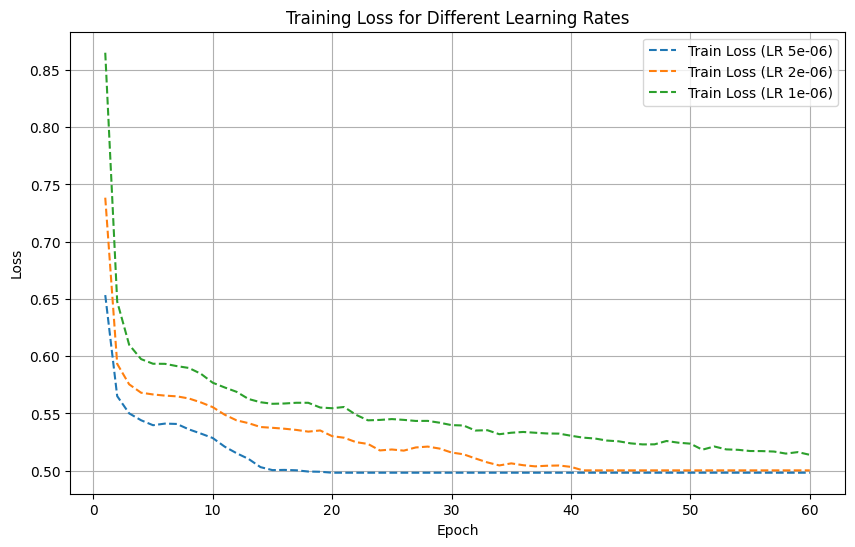

In [ ]:
# Plots the results

plt.figure(figsize=(10, 6))

for lr, losses in all_train_losses.items():
    plt.plot(range(1, EPOCHS + 1), losses, label=f"Train Loss ({lr})", linestyle="dashed")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss for Different Learning Rates")
plt.legend()
plt.grid()
plt.show()


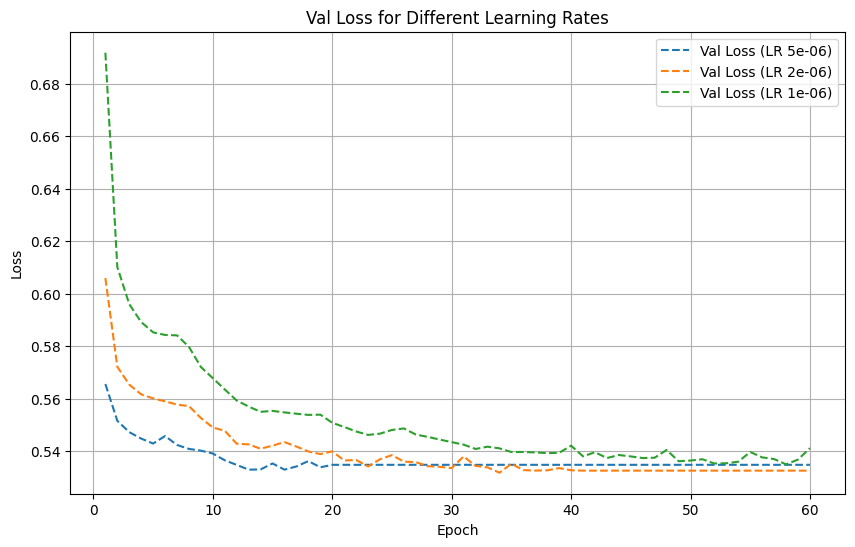

In [ ]:
# 📊 Plotando os resultados
plt.figure(figsize=(10, 6))

for lr, losses in all_val_losses.items():
    plt.plot(range(1, EPOCHS + 1), losses, label=f"Val Loss ({lr})", linestyle="dashed")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Val Loss for Different Learning Rates")
plt.legend()
plt.grid()
plt.show()

In the end, we've got the following accuracies on the validation set for all learning rates:

- 5e-6 : 77.26%
- 2e-6 : 77.31%
- 1e-6 : 77.07%

Therefore, well pick the second one to be our representative of neural network performance (there are way more tests we've tried, but this is the set of parameters and architecture that had the best behaved curves and loss values, without neither overfit nor underfit)!  

In [ ]:
CHOSEN_LR = 2e-6

neural_net_model = SentimentClassifier().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(neural_net_model.parameters(), lr=CHOSEN_LR, weight_decay=1e-5)  # Slight L2 Regularization
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)  # Gradual LR reduction

best_val_loss = float("inf")
patience_counter = 0

# Go through all epochs
for epoch in range(EPOCHS):
  train_loss = train(neural_net_model, embedding_train_loader, optimizer, criterion, epoch)
  val_loss, val_acc = test(neural_net_model, embedding_val_loader, criterion, epoch)

  # Update the learning rate with the scheduler
  scheduler.step()

  # Early Stopping: stop if the validation loss hasn't got any better for "PATIENCE" epochs
  if val_loss < best_val_loss:
    best_val_loss = val_loss
    patience_counter = 0
  else:
    patience_counter += 1
    if patience_counter >= PATIENCE:
      print(f"⏹️ Early Stopping activated in epoch {epoch+1}.")
      break

| Epoch [  0/ 60] Iter[  1/  6]		Loss: 1.1379 Acc@1: 28.125%
| Epoch [  0/ 60] Iter[ 51/  6]		Loss: 0.8817 Acc@1: 49.908%
| Epoch [  0/ 60] Iter[101/  6]		Loss: 0.7890 Acc@1: 58.617%
| Epoch [  0/ 60] Iter[151/  6]		Loss: 0.6975 Acc@1: 62.841%
| Epoch [  0/ 60] Iter[201/  6]		Loss: 0.6807 Acc@1: 65.197%
| Epoch [  0/ 60] Iter[251/  6]		Loss: 0.6788 Acc@1: 66.951%
| Epoch [  0/ 60] Iter[301/  6]		Loss: 0.6710 Acc@1: 68.060%

| Validation Epoch #0			Loss: 0.7258 Acc@1: 74.34%
| Epoch [  1/ 60] Iter[  1/  6]		Loss: 0.5364 Acc@1: 79.688%
| Epoch [  1/ 60] Iter[ 51/  6]		Loss: 0.6401 Acc@1: 74.234%
| Epoch [  1/ 60] Iter[101/  6]		Loss: 0.6638 Acc@1: 74.288%
| Epoch [  1/ 60] Iter[151/  6]		Loss: 0.6542 Acc@1: 74.483%
| Epoch [  1/ 60] Iter[201/  6]		Loss: 0.5190 Acc@1: 74.821%
| Epoch [  1/ 60] Iter[251/  6]		Loss: 0.5150 Acc@1: 74.807%
| Epoch [  1/ 60] Iter[301/  6]		Loss: 0.5820 Acc@1: 74.683%

| Validation Epoch #1			Loss: 0.5052 Acc@1: 75.69%
| Epoch [  2/ 60] Iter[  1/  6]		Loss: 0.5

# Finetuning-Based

In [ ]:
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [ ]:
def compute_metrics(eval_pred):
    """
    Computes accuracy using sklearn's accuracy_score for consistency with other evaluations.
    """
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {"accuracy": accuracy_score(labels, predictions)}

## Classic

**Q4** - please use an LLM compare your performences to a LLM

In [ ]:
bert = AutoModelForSequenceClassification.from_pretrained(PRETRAINED_MODEL, num_labels = 3)

print_trainable_parameters(bert)

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

trainable params: 124647939 || all params: 124647939 || trainable%: 100.0


In [ ]:
# Define training arguments
training_args = TrainingArguments(
    output_dir=os.path.join(".", 'results_no_LoRA'),
    evaluation_strategy="epoch",
    num_train_epochs=1,
    report_to="none"  # Deactivates wandb
)


# Initialize Trainer
trainer = Trainer(
    model=bert,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.506300,0.509859,0.801492


TrainOutput(global_step=2748, training_loss=0.5738416280288363, metrics={'train_runtime': 1200.6133, 'train_samples_per_second': 18.311, 'train_steps_per_second': 2.289, 'total_flos': 2892142687666176.0, 'train_loss': 0.5738416280288363, 'epoch': 1.0})

In [ ]:
# Save the fine-tuned model and configuration
output_dir = os.path.join('.', 'results_no_LoRA')
trainer.model.save_pretrained(output_dir)
trainer.save_model(output_dir)
trainer.model.config.save_pretrained(output_dir)

## LoRA

**Q7** - please finetue with LORA an LLM to classify the sentiment (optional)

In [ ]:
# the rank you want to decompose matrices
r = 2
lora_config = LoraConfig(task_type=TaskType.SEQ_CLS, r=r, lora_alpha=1, lora_dropout=0.1)

bert = AutoModelForSequenceClassification.from_pretrained(PRETRAINED_MODEL, num_labels = 3)
bert_lora = get_peft_model(bert, lora_config)

In [ ]:
print_trainable_parameters(bert_lora)

trainable params: 666627 || all params: 125314566 || trainable%: 0.531962900466016


In [ ]:
training_args_lora = TrainingArguments(
    output_dir=os.path.join(".", 'results_LoRA'),
    evaluation_strategy="epoch",
    num_train_epochs=1,
    report_to="none"  # Deactivates wandb
)

# Initialize Trainer
trainer_lora = Trainer(
    model=bert_lora,
    args=training_args_lora,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer_lora.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.557200,0.563665,0.766921


TrainOutput(global_step=2748, training_loss=0.5902157912608318, metrics={'train_runtime': 795.9095, 'train_samples_per_second': 27.621, 'train_steps_per_second': 3.453, 'total_flos': 2914652964225024.0, 'train_loss': 0.5902157912608318, 'epoch': 1.0})

In [ ]:
# Save the fine-tuned model and configuration
output_dir = os.path.join('.', 'results_LoRA')
trainer_lora.model.save_pretrained(output_dir)
trainer_lora.save_model(output_dir)
trainer_lora.model.config.save_pretrained(output_dir)

# LLM API

In order to provide a richer discussion, we've designed an experiment in which we make API calls to a more recent (and larger) LLM: Deepseekv3.

The goal of this section is to verify, given the predictive power of these larger auto-regressive models, until what extent can the dataset be mastered, in other words, is it possible to achieve very good accuracy ?    

Let's begin !

We've used the llama-API for querying bigger models hosted in the cloud as to what they think the proper label should be for a subset (of size one hundreded) of the training dataset. This choice stems from the fact that these API calls are very slow, averaging 1 classification per minute. We are not sure as to why, but it seemed that the newer DeepSeekv3 model was the most consistent (and faster) in this regard. Therefore, we opted to used it.  

The procedure can be basically summed up as sending a JSON with the query, contextualizing DeepSeek of it's role of sentiment classifier, and get it's response. At every 5 responses, for safety reasons, we've decided to implement a basic checkpointing mechanism. If the API stopped responding (or, for whatever reason, we decided to end the program) we could've not lost much progress, as the process has a verification step before sending the query (to see if it has already sent it before).

*Examples of how the system would act while running (notice we didn't add any preprocessing to this part, as these models are pretty robust to these)*
> 📌 Tweet:  Enjoy! Family trumps everything

> 🟢 Predict: positive

> 🔵 Real: positive

> 📌 Tweet:  --of them kinda turns me off of it all.  And then I buy more of them and dig a deeper hole, etc. ;;

> 🟢 Predict: negative

> 🔵 Real: negative

> 📌 Tweet: Clive it`s my birthday pat me  http://apps.facebook.com/dogbook/profile/view/6386106

> 🟢 Predict: neutral

> 🔵 Real: neutral

> 💾 Checkpoint saved !

>  Error detected ! : Expecting value: line 1 column 1 (char 0). Waiting 10 seconds before retry ...

(*sometimes the server didn't respond*)

Lets load the checkpoint.json file and see what were the results.

In [ ]:
API_path = "MI201-groupe-4/API/"

In [ ]:
# Open the json file as a DataFrame
df_deepseek = pd.read_json(API_path + 'checkpoint.json')
df_deepseek

,processed_tweets
Enjoy! Family trumps everything,positive
"--of them kinda turns me off of it all. And then I buy more of them and dig a deeper hole, etc. ;;",negative
Clive it`s my birthday pat me http://apps.facebook.com/dogbook/profile/view/6386106,neutral
congrats hey,neutral
Do you have any idea when the (not so) patient fans will see some teaser pics of you all in costume?,neutral
...,...
"....what did she EVER do to piss them off? I thought you just meant casting-related ****, not more of that ****.",neutral
Morning everybody,neutral
http://twitpic.com/4wh4d - LAUREN is AMAZING....well from what I see on the hills lol Seem like a great friend to have!!,positive
ohhhhh with ya,neutral


In the end, we had the following result:

✅ Process finished ! Checkpoint saved .

---


Accuracy: 0.7

  Classification Report:
                  precision    recall  f1-score   support

      positive       0.88      0.48      0.62        29
      negative       0.58      0.95      0.72        37
      neutral        0.88      0.62      0.72        34

      accuracy                            0.70       100
      macro avg       0.78      0.68      0.69       100
      weighted avg    0.77      0.70      0.69       100

Which can be better visualized as a confusion matrix


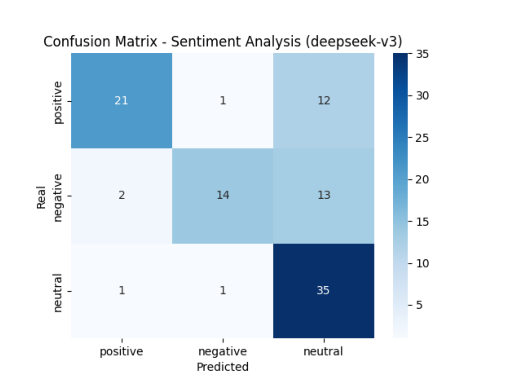

In [ ]:
image_path = os.path.join(API_path, "deepseekv3ConfMatrix.png")
image = Image.open(image_path)

plt.imshow(image)
plt.axis("off")
plt.show()

As we can see, there are some good hypothesis that we can now test:

- Discerning `positive` from `negative` doesn't seem to be a challenge in this dataset, however, nearly 42% of the times the model judged that the sentence was `neutral`, it seemed like it wasn't, with errors identical to the other 2 labels. This suggests that improving the classifiers abilities to discern better between these classes (perhaps by introducing a weighted penalty, with higher penalty for mistaking for the neutral class) is a major change point. Then again, the dataset is imbalanced towards the `neutral` label, so perhaps just using some technique like [SMOTE](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html) can be enough. Then again, we need to remember that perhaps it's more likely that most real life tweets are indeed `neutral`, so the model having a higher tendency of classifing as this class could be an advantage (we also need to be aware of the distributional shift that exists before taking this side of things). The t-sne projections already gave us a preview earlier that this was, infact, the case, therefore validating it's reliability for future improvements, probably in a feature engineering setting.

> **Context**

> There's a story behind every dataset and here's your opportunity to share yours.
training data was automatically created, as opposed to having humans manual annotate tweets. In our approach, we assume that any tweet with positive emoticons, like :), were positive, and tweets with negative emoticons, like :(, were negative.

- The dataset's labels, as by exposed [in it's original Kaggel forum](https://www.kaggle.com/datasets/abhi8923shriv/sentiment-analysis-dataset/data), were generated in a self supervised manner, with a simple emoji heuristic. So it's likely not even safe to use this data as a representative sample of the real world problem's distribution. As already discussed in the preProcessingAndEDA notebook, it seems like the dataset isn't natural at all given the abnormal uniformity of the non-text labels.

- It seems like the most we can realistically expect in terms of accuracy in this dataset is about 70%. Even before estimating it in the test set we can probably expect the generalization error to be around this much, as all the models were somewhat around this value anyways on the validation set.



# Discussion and Results

**Q3** - please analyse all the performences and explain which is the best

- Discuss the embeddings, with t-SNE, making a point in what strategy (Feature-based or Fine tuning) worked best (comment on other bert's results and the effect of adding the other features in the datasets)

In [ ]:
# Feature-based Approach

# Classical ML
rf = RandomForestClassifier(**rf_best_params)
rf.fit(train_embeddings_umap, y_train)

accuracy = rf.score(test_embeddings_umap, y_test)
print(f"RF Test Accuracy: {accuracy:.4f}")

# Deep Learning
criterion = nn.CrossEntropyLoss()

nn_total_test_loss = 0
nn_total_test_acc = 0

for epoch in range(EPOCHS):
  nn_test_loss, nn_test_acc = test(neural_net_model, embedding_test_loader, criterion, epoch)
  nn_total_test_loss += nn_test_loss
  nn_total_test_acc += nn_test_acc
print(f"NN Test Accuracy: {nn_total_test_acc/EPOCHS:.4f}")

# Finetuning Approach

# Basic
finetuning_test_pred = trainer.predict(test_dataset)
finetuning_logits = finetuning_test_pred.predictions
finetuning_labels = finetuning_test_pred.label_ids
finetuning_preds = np.argmax(finetuning_logits, axis = 1)
finetuning_acc = np.mean(finetuning_preds == finetuning_labels)
print(f"Finetuning BERT Test Accuracy: {finetuning_acc:.4f}")

finetuning_lora_test_pred = trainer_lora.predict(test_dataset)
finetuning_lora_logits = finetuning_lora_test_pred.predictions
finetuning_lora_labels = finetuning_lora_test_pred.label_ids
finetuning_lora_preds = np.argmax(finetuning_lora_logits, axis = 1)
finetuning_lora_acc = np.mean(finetuning_lora_preds == finetuning_lora_labels)
print(f"Finetuning (LoRA) BERT Test Accuracy: {finetuning_lora_acc:.4f}")

RF Test Accuracy: 0.2643

| Validation Epoch #0			Loss: 1.2743 Acc@1: 48.81%

| Validation Epoch #1			Loss: 2.4553 Acc@1: 48.81%

| Validation Epoch #2			Loss: 1.9193 Acc@1: 48.81%

| Validation Epoch #3			Loss: 1.4496 Acc@1: 48.81%

| Validation Epoch #4			Loss: 1.7933 Acc@1: 48.81%

| Validation Epoch #5			Loss: 1.6145 Acc@1: 48.81%

| Validation Epoch #6			Loss: 1.9718 Acc@1: 48.81%

| Validation Epoch #7			Loss: 1.9759 Acc@1: 48.81%

| Validation Epoch #8			Loss: 2.4090 Acc@1: 48.81%

| Validation Epoch #9			Loss: 2.3571 Acc@1: 48.81%

| Validation Epoch #10			Loss: 1.6167 Acc@1: 48.81%

| Validation Epoch #11			Loss: 1.6000 Acc@1: 48.81%

| Validation Epoch #12			Loss: 1.3315 Acc@1: 48.81%

| Validation Epoch #13			Loss: 2.2472 Acc@1: 48.81%

| Validation Epoch #14			Loss: 0.9468 Acc@1: 48.81%

| Validation Epoch #15			Loss: 1.8235 Acc@1: 48.81%

| Validation Epoch #16			Loss: 2.0827 Acc@1: 48.81%

| Validation Epoch #17			Loss: 1.1854 Acc@1: 48.81%

| Validation Epoch #18			Loss:

Finetuning BERT Test Accuracy: 0.8031


Finetuning (LoRA) BERT Test Accuracy: 0.7558


As we can see, we had the following results for our model based upon the `cardiffnlp/twitter-roberta-base-sentiment` BERT model :

**Validation**:

|    Classic ML   |    Neural Net   |    Finetuning   | LoRA Finetuning |
|:---------------:|:---------------:|:---------------:|:---------------:|
|                 |                 |                 |                 |
|       76%       |       77%       |       80%       |       77%       |
|                 |                 |                 |                 |

**Test**:

|    Classic ML   |    Neural Net   |    Finetuning   | LoRA Finetuning |
|:---------------:|:---------------:|:---------------:|:---------------:|
|                 |                 |                 |                 |
|       26%       |        49%      |        80%      |        76%      |
|                 |                 |                 |                 |


This shows a very good translation of the models from the training setting to the test. We can see that the finetuning approaches generalized way better, with an (estimated) generalization error near the discussed most likely maximum (approximately 77%). The reasons as to why this is the case requires further investigation.

We've tried to add the other features from the tweet dataset, that involves a sort of cultural and demographical contextualization. As previewed in the pre-processing notebook, there wasn't that much of an improvement (sometimes the accuracy decreased). This is likely due to the strange homogeneity that it possesses. We didn't find much time to exhibit an honest analysis of this, so the results and procedure are not shown here.